In [1]:
import numpy as np
from numpy import linalg
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
images = []
for file in tqdm(Path('data/faces94').rglob('*.jpg')):
    image = cv2.imread(str(file))
    images.append(image)
faces = np.stack(images) / 255

3059it [00:03, 1008.01it/s]


In [3]:
face_shape = faces[0].shape
N = faces.shape[0]

## The average face

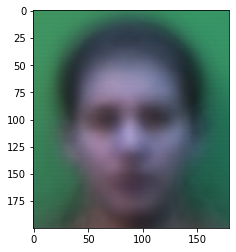

In [4]:
mean_face = faces.mean(0)
plt.imshow(mean_face)
plt.show()

## Ghost Images

In [5]:
X = faces.reshape((faces.shape[0], -1))
X_bar = X - mean_face.reshape(-1)
S = X_bar @ X_bar.T / N
eig_values, small_eig_vectors = linalg.eigh(S)

In [7]:
eig_vectors = X_bar.T @ small_eig_vectors[:, -500:]
eig_vectors = eig_vectors / (eig_values[-500:] * N) ** 0.5

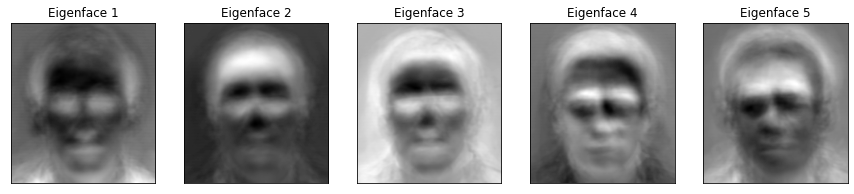

In [8]:
def channel_min(arr):
    return np.amin(arr, (0, 1))

def channel_max(arr):
    return np.amax(arr, (0, 1))

fig, axes = plt.subplots(ncols=5, figsize=(15, 5))
for i in range(5):
    axis = axes[i]
    eigenface = eig_vectors[:, -i-1].reshape(face_shape)
    axis.imshow(eigenface.mean(-1), cmap='gray')
#     eigenface =  eigenface - channel_min(eigenface)
#     eigenface = eigenface / channel_max(eigenface)
#     eigenface = np.clip(eigenface, 0, 1)
#     axis.imshow(eigenface)
    axis.set_title(f'Eigenface {i+1}')
    axis.set_xticks([])
    axis.set_yticks([])
    print()
plt.show()

## PCA Reconstruction

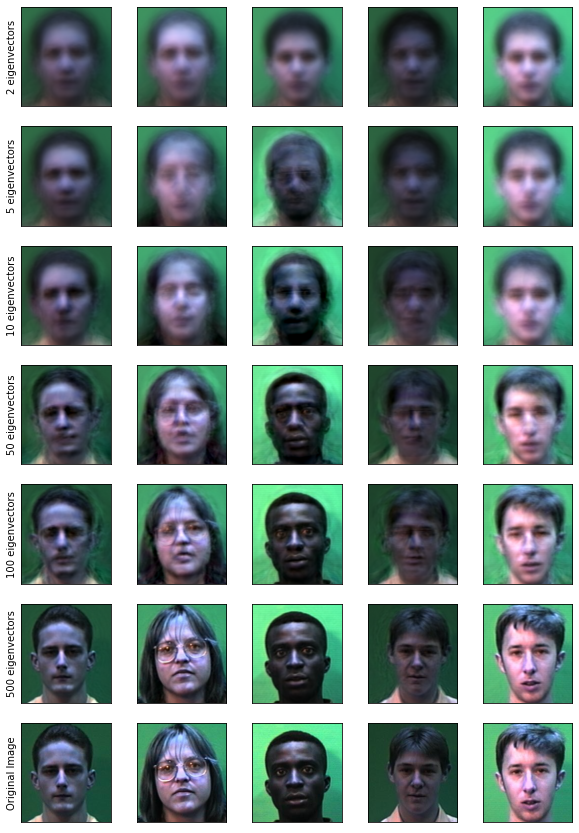

In [12]:
num_eig_list = [2, 5, 10, 50, 100, 500]
plt.figure(figsize=(10, 15))
indices = np.random.randint(N, size=5)
X_sample = X_bar[indices]
for i, num_eig in enumerate(num_eig_list):
    eig_vectors_ = eig_vectors[:, -num_eig:]
    reconst = X_sample @ eig_vectors_ @ eig_vectors_.T
    for j, im in enumerate(reconst):
        plt.subplot(7, 5, i * 5 + j + 1)
        if j == 0:
            plt.ylabel(f'{num_eig} eigenvectors')
        plt.imshow(np.clip(mean_face + im.reshape(face_shape), 0, 1))
        plt.xticks([])
        plt.yticks([])
        
for j, sample in enumerate(X_sample):
    plt.subplot(7, 5, 31 + j)
    if j == 0:
        plt.ylabel('Original Image')
    plt.imshow(np.clip(mean_face + sample.reshape(face_shape), 0, 1))
    plt.xticks([])
    plt.yticks([])

plt.suptitle('')
    
plt.show()

When few eigenvectors are used, the reconstructions are very similar to the average image, however, when more are used, the image becomes more and more similar to the original image.

## Similarity Metric

In [11]:
def similarity_metric(im1, im2, eps=1):
    im1_weights = im1 @ eig_vectors
    im2_weights = im2 @ eig_vectors
    dist = linalg.norm(im1_weights - im2_weights)
    return dist <= eps

## Finding minimal amount of necessary eigenvectors

In [24]:
cum_var = np.cumsum(eig_values[::-1]) / eig_values.sum()
min_eig = np.where(cum_var > 0.95)[0][0]
print('The minimal necessary amount of eigenvalues is {}'.format(min_eig))

The minimal necessary amount of eigenvalues is 179


### Loading Test Images

In [83]:
test_images = []
labels = []
for imdir in Path('data/test_images_pair/').iterdir():
    images = []
    for file in imdir.iterdir():
        image = cv2.imread(str(file)) 
        image = image / 255 - mean_face
        image = image.reshape(-1)
        images.append(image)
    test_images.append(images)
    labels.append(True)

### Creatning Negative Samples

In [84]:
for i in range(len(test_images)):
    im1 = test_images[i][1]
    im2 = test_images[i+1][0] if i < len(test_images) - 1 else test_images[0][0]
    test_images.append((im1, im2))
    labels.append(False)

### Finding the appropriate value of $\epsilon$

In [114]:
for eps in [10, 20, 50, 80]:
    predictions = []
    for im1, im2 in test_images:
        pred = similarity_metric(im1, im2, eps=eps)
        predictions.append(pred)
    accuracy = sum(pred == label for pred, label in zip(predictions, labels)) / len(labels)
    print(f'eps: {eps:.0e} accuracy: {accuracy:.2%}')

eps: 1e+01 accuracy: 50.00%
eps: 2e+01 accuracy: 55.00%
eps: 5e+01 accuracy: 90.00%
eps: 8e+01 accuracy: 80.00%


$\epsilon = 50$ gets us accuracy of $90\%$.